## 8 faces fine tuning 
In this nootebook we want to do some transfer learning to get a better classification performance on the data set with the 8 celebreties. For this we use a pretrained vgg16 network. We push each image through the trained VGG16 net and fetch the entries in the fc1 layer which we will use as CNN-feature representation of the respective image. The fetching of these CNN features is already done in another notbook (since loading of VGG16 including the top layer requires some time and space). Here we load '8_faces_EMB.npz' containing the CNN feature representation which were obtained by a pretrained VGG16. Then we train a fully connected network with these CNN-features and our own labels - this is called transfer learning since the feature extractor was learned on another data set (1 million images from iamgeNet with 1000 class labels).

In [1]:
import gzip
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as imgplot
import time
%matplotlib inline
import h5py
from scipy import misc
import os
import random

C:\Users\Daniel\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Load the dataset that contains the CNN-feature representation of the 8-faces data set (because of computational reasons we just load them)

In [2]:
# Downloading the data, if it does not exist
import urllib
import os
if not os.path.isfile('8_faces_EMB.npz'):
    urllib.request.urlretrieve(
    "https://www.dropbox.com/s/3w3x9i7ng7017l3/8_faces_EMB.npz?dl=1",
    "8_faces_EMB.npz")
%ls -hl 8_faces_EMB.npz

 Datentr„ger in Laufwerk D: ist Data
 Volumeseriennummer: D012-F8ED

 Verzeichnis von D:\code\tsm-machle\week-05


 Verzeichnis von D:\code\tsm-machle\week-05

20.03.2018  16:56        49'863'217 8_faces_EMB.npz
               1 Datei(en),     49'863'217 Bytes
               0 Verzeichnis(se), 126'419'042'304 Bytes frei


In [3]:
Data=np.load("8_faces_EMB.npz")
print(Data.files)
X_train = Data["arr_0"]
X_valid = Data["arr_1"]
X_test =  Data["arr_2"]
Y_train = Data["arr_3"]
Y_valid = Data["arr_4"]
Y_test =  Data["arr_5"]
print(X_train.shape)
print(X_valid.shape)
print(Y_train.shape)
print(Y_valid.shape)
print(X_test.shape)
print(Y_test.shape)

['arr_1', 'arr_0', 'arr_3', 'arr_2', 'arr_5', 'arr_4']
(2000, 4096)
(400, 4096)
(2000,)
(400,)
(400, 4096)
(400,)


In [4]:
def convertToOneHot(vector, num_classes=None):
    result = np.zeros((len(vector), num_classes), dtype='int32')
    result[np.arange(len(vector)), vector] = 1
    return result

In [5]:
Y_train=convertToOneHot(Y_train,num_classes=8)
Y_valid=convertToOneHot(Y_valid,num_classes=8)

In [6]:
batch_size = 128
nb_classes = 8
nb_epoch = 30

In [7]:
import keras
from keras.layers import Dense, Activation, Dropout, BatchNormalization
from keras.models import Sequential


Using TensorFlow backend.


#### Define the network

In [10]:
model = Sequential()
name = '8_faces_finetune'

model.add(Dense(400,init='he_normal',batch_input_shape=((None,4096))))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.4))
## Your code here
model.add(Dense(400,init='he_normal',batch_input_shape=((None,400))))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dropout(0.4))
model.add(Dense(8,init='he_normal',batch_input_shape=((None, 400))))

## end of your code
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

C:\Users\Daniel\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(400, batch_input_shape=(None, 409..., kernel_initializer="he_normal")`
  after removing the cwd from sys.path.
C:\Users\Daniel\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(400, batch_input_shape=(None, 400..., kernel_initializer="he_normal")`
  if __name__ == '__main__':
C:\Users\Daniel\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(8, batch_input_shape=(None, 400..., kernel_initializer="he_normal")`
  


In [11]:
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 400)               1638800   
_________________________________________________________________
batch_normalization_3 (Batch (None, 400)               1600      
_________________________________________________________________
activation_5 (Activation)    (None, 400)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 400)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 400)               160400    
_________________________________________________________________
batch_normalization_4 (Batch (None, 400)               1600      
_________________________________________________________________
activation_6 (Activation)    (None, 400)               0         
__________

In [12]:
tensorboard = keras.callbacks.TensorBoard(
        log_dir='tensorboard/8_faces/' + name + '/', 
        write_graph=True,
        histogram_freq=1)

#### Training the network


In [13]:
history=model.fit(X_train, Y_train, 
                  batch_size=batch_size, 
                  nb_epoch=nb_epoch,
                  verbose=1, 
                  validation_data=(X_valid, Y_valid),
                  callbacks=[tensorboard])

C:\Users\Daniel\Anaconda3\lib\site-packages\keras\models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 2000 samples, validate on 400 samples
Epoch 1/30
2000/2000 [==============================] - 1s 654us/step - loss: 1.5516 - acc: 0.4515 - val_loss: 1.0734 - val_acc: 0.6275
Epoch 2/30
2000/2000 [==============================] - 1s 578us/step - loss: 0.9694 - acc: 0.6580 - val_loss: 0.8456 - val_acc: 0.7125
Epoch 3/30
2000/2000 [==============================] - 1s 612us/step - loss: 0.7236 - acc: 0.7530 - val_loss: 0.8420 - val_acc: 0.7050
Epoch 4/30
2000/2000 [==============================] - 1s 586us/step - loss: 0.5950 - acc: 0.7990 - val_loss: 0.7530 - val_acc: 0.7475
Epoch 5/30
2000/2000 [==============================] - 1s 592us/step - loss: 0.4623 - acc: 0.8500 - val_loss: 0.7649 - val_acc: 0.7425
Epoch 6/30
2000/2000 [==============================] - 1s 600us/step - loss: 0.3917 - acc: 0.8740 - val_loss: 0.6739 - val_acc: 0.7775
Epoch 7/30
2000/2000 [==============================] - 1s 591us/step - loss: 0.3280 - acc: 0.8940 - val_loss: 0.7746 - val_acc: 0.7275
E

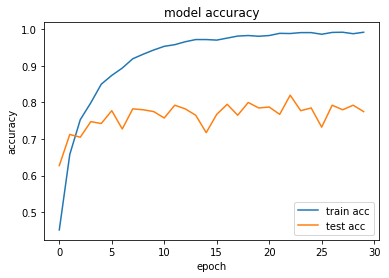

In [14]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train acc', 'test acc'], loc='lower right')
plt.show()

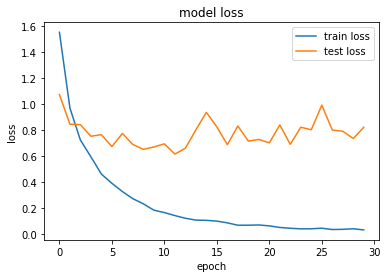

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'test loss'], loc='upper right')
plt.show()

#### Evaluation of the trained network


In [16]:
preds=np.zeros([len(X_test),8])
for i in range(0,len(X_test)):
    preds[i]=model.predict(X_test[i].reshape(1,4096))

In [17]:
pred=np.zeros([len(X_test)])
for i in range(0,len(X_test)):
    pred[i]=np.argmax(preds[i])

In [18]:
sum(pred==Y_test)/400.


0.815

In [19]:
from sklearn.metrics import confusion_matrix
confusion_matrix(Y_test, pred)

array([[36,  1,  1,  2,  2,  1,  6,  1],
       [ 0, 32,  0,  6,  6,  4,  1,  1],
       [ 1,  0, 47,  0,  0,  1,  1,  0],
       [ 0,  0,  0, 47,  0,  1,  2,  0],
       [ 0,  3,  0,  0, 44,  1,  2,  0],
       [ 0,  1,  0,  4,  2, 39,  4,  0],
       [ 0,  0,  0,  2,  0,  3, 44,  1],
       [ 1,  1,  2,  2,  3,  1,  3, 37]], dtype=int64)

In [20]:
# Downloading the data, if it does not exist
if not os.path.isfile('Data_test_8_faces_no_cut_100_100.hdf5'):
    urllib.request.urlretrieve(
    "https://www.dropbox.com/s/1oe2cglv2xeb4bg/Data_test_8_faces_no_cut_100_100.hdf5?dl=1",
    "Data_test_8_faces_no_cut_100_100.hdf5")
%ls -hl Data_test_8_faces_no_cut_100_100.hdf5

 Datentr„ger in Laufwerk D: ist Data
 Volumeseriennummer: D012-F8ED

 Verzeichnis von D:\code\tsm-machle\week-05


 Verzeichnis von D:\code\tsm-machle\week-05

20.03.2018  17:09        96'005'344 Data_test_8_faces_no_cut_100_100.hdf5
               1 Datei(en),     96'005'344 Bytes
               0 Verzeichnis(se), 126'304'325'632 Bytes frei


In [21]:
h5f_X = h5py.File('Data_test_8_faces_no_cut_100_100.hdf5', 'r')
print(list(h5f_X.keys()))
X_test = h5f_X['X_test_8_faces']
print(X_test.shape)
Y_test = h5f_X['Y_test_8_faces']
print(Y_test.shape)


['X_test_8_faces', 'Y_test_8_faces']
(400, 100, 100, 3)
(400,)


#### Visualize right and wrong classified images

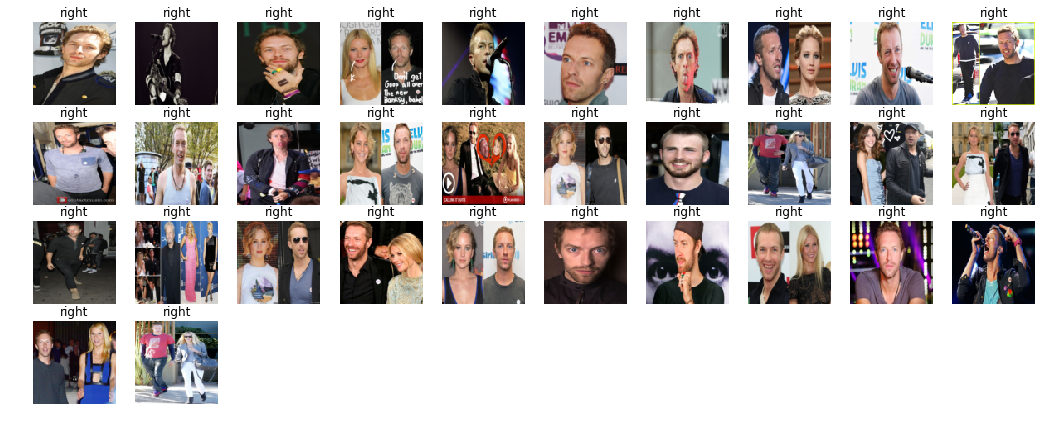

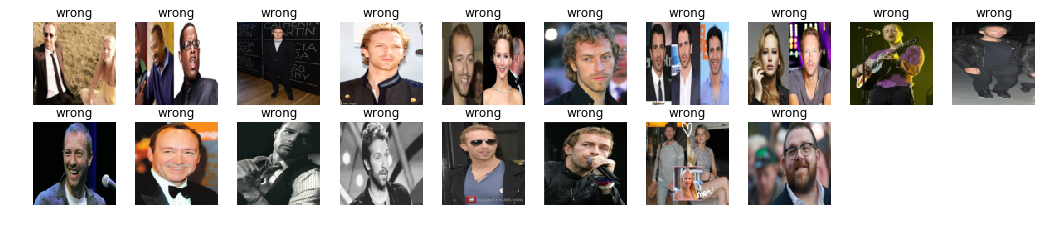

In [22]:
Klasse=1
right = np.where(Y_test[:]==Klasse)[0][np.where(np.in1d(np.where(Y_test[:]==Klasse),np.where(pred[:]==Klasse)))]
wrong = np.where(Y_test[:]==Klasse)[0][(np.in1d(np.where(Y_test[:]==Klasse),np.where(pred[:]==Klasse)))==False]

plt.figure(figsize=(18,18))
for i in range(0,len(right)):
    plt.subplot(10,10,(i+1))
    plt.imshow(np.asarray(X_test[right[i]],dtype="uint8"))
    plt.axis('off')
    plt.title('right')
    
plt.figure(figsize=(18,18))
for i in range(0,len(wrong)):
    plt.subplot(10,10,(i+1))
    plt.imshow(np.asarray(X_test[wrong[i]],dtype="uint8"))
    plt.axis('off')
    plt.title('wrong')